In [1]:
from planner.data import AV2DataModule
from planner.data.viz import plot_scenario

In [2]:
dm = AV2DataModule(
    batch_size=1,
    root="/media/csuser/DATA/seneva/data/av2/",
    radius=50.0,
    num_workers=1,
    pin_memory=True,
    train=False,
    val=True,    
    test=False,
)
dl = iter(dm.val_dataloader())

RADIUS:  50.0


In [3]:
ds = dm.val_dataset
print(ds)

In [4]:
data = next(dl)

print(data)

Scenario(batch_dims=torch.Size([1]), num_map_points=10000, num_objects=288)


Type of ax: <class 'matplotlib.axes._axes.Axes'>
Type of ax after plot map: <class 'matplotlib.axes._axes.Axes'>
Type of ax after _plot_agents: <class 'matplotlib.axes._axes.Axes'>


<Axes: >

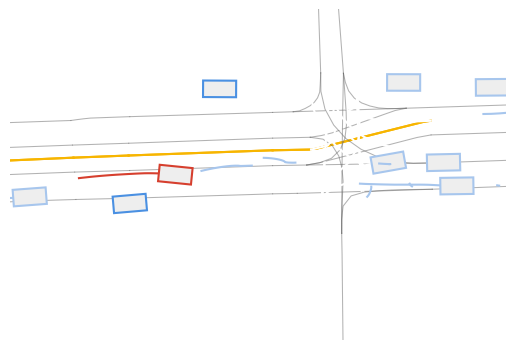

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plot_scenario(scenario=data[0], ax=ax)


In [6]:
from planner.model.senevam import SeNeVAMLightningModule
import torch
ckpt_path = '/media/csuser/DATA/seneva_multi/logs/train/runs/senevam_av2_radius_50/2025-10-01_21-57-39/checkpoints/epoch_011_697f404.ckpt'
model = SeNeVAMLightningModule.load_from_checkpoint(
    ckpt_path,
    map_location="cpu",
    strict=True,
)
model.eval()
#print(data)
model.forward(scenario=data, horizon=80)
# NOTE: equivanlently
with torch.no_grad():
    current, curr_valid = model.get_current(scenario=data, include_sdc=False)
    target, tar_valid = model.get_target(scenario=data, include_sdc=False)
    output = model.forward(scenario=data, horizon=84, include_sdc=False)[0]
print(current.shape, curr_valid.shape)
print(target.shape, tar_valid.shape)
#print(output)
print(output.y_means.shape, output.y_covars.shape)
print(data[0].log_trajectory.shape)

 AT t =  0  Guidance score:  150.99693298339844
 AT t =  1  Guidance score:  150.9998016357422
 AT t =  2  Guidance score:  151.0028839111328
 AT t =  3  Guidance score:  151.25270080566406
 AT t =  4  Guidance score:  152.3318634033203
 AT t =  5  Guidance score:  154.11407470703125
 AT t =  6  Guidance score:  157.59547424316406
 AT t =  7  Guidance score:  168.63742065429688
 AT t =  8  Guidance score:  213.7411346435547
 AT t =  9  Guidance score:  401.78594970703125
 AT t =  0  Guidance score:  175.13607788085938
 AT t =  1  Guidance score:  175.16929626464844
 AT t =  2  Guidance score:  175.50714111328125
 AT t =  3  Guidance score:  176.3931427001953
 AT t =  4  Guidance score:  177.80792236328125
 AT t =  5  Guidance score:  180.51634216308594
 AT t =  6  Guidance score:  187.30352783203125
 AT t =  7  Guidance score:  206.26235961914062
 AT t =  8  Guidance score:  264.1459045410156
 AT t =  9  Guidance score:  442.5105285644531
 AT t =  0  Guidance score:  152.79153442382812

In [7]:
# Helper function: Plot the heatmap of uncertainty
# NOTE: this function is for single-agent heatmap plotting
# TODO: consider about adding log-prob up or other ways to aggregate
# multi-agent probabilities
from typing import Any, Literal, Optional
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt
def plot_full_uncertainty(
    means: npt.NDArray,
    covars: npt.NDArray,
    mixtures: npt.NDArray,
    ax: Optional[plt.Axes] = None,
    n_std: int = 1,
    heatmap_type: Literal["prob", "log_prob", "logit"] = "log_prob",
    colorbar: bool = True,
    *args: Any,
    **kwargs: Any,
) -> plt.Axes:
    if ax is None:
        _, ax = plt.subplots(1, 1)

    # step 1: obtain the rectangle region covering at least 68%
    # of the probability density function
    minx = np.min(means[:, :, 0] - n_std * np.sqrt(covars[..., 0, 0]))
    maxx = np.max(means[:, :, 0] + n_std * np.sqrt(covars[..., 0, 0]))
    miny = np.min(means[:, :, 1] - n_std * np.sqrt(covars[..., 1, 1]))
    maxy = np.max(means[:, :, 1] + n_std * np.sqrt(covars[..., 1, 1]))

    probs, mask = [], []

    # NOTE: efficient way to evaluate prob
    x, y = np.linspace(minx, maxx, 100), np.linspace(miny, maxy, 100)
    x, y = np.meshgrid(x, y)
    points = np.vstack((x.ravel(), y.ravel())).T  # shape (10000, 2)

    for mean, covar, pi in zip(means, covars, mixtures):
        # calculate the Gaussian probability density function
        inv_covar = np.linalg.inv(covar)  # shape (T, 2, 2)
        det_covar = np.linalg.det(covar)  # shape (T,)
        diff = points[:, None, ...] - mean[None, ...]  # shape (10000, T, 2)
        mahalanobis = np.einsum("btj, tij, bti -> bt", diff, inv_covar, diff)
        log_prob = -0.5 * (
            mahalanobis + np.log(det_covar + 1e-10) + 2 * np.log(2 * np.pi)
        )
        log_prob += np.log(pi + 1e-10)
        probs.append(np.exp(log_prob))

        # TODO: aggregate the probabilities from multiple agents?

        # NOTE: filter out outliers
        mask.append(
            np.reshape(
                np.all(mahalanobis > n_std * math.sqrt(2), -1),
                (100, 100),
            ).astype(bool)
        )
    mask = np.all(mask, axis=0)

    probs = np.stack(probs, axis=0)
    probs = np.mean(np.sum(probs, axis=0), axis=-1)
    probs = np.reshape(probs, (100, 100))
    probs = np.ma.masked_where(mask, probs)
    if heatmap_type == "log_prob":
        probs = np.log(probs + 1e-10)
        heatmap_name = "Log-Probability"
    elif heatmap_type == "logit":
        probs = np.log((probs + 1e-10) / (1 - probs - 1e-10))
        heatmap_name = "Logit"
    else:
        heatmap_name = "Probability"
    cbar = ax.contourf(x, y, probs, *args, **kwargs)

    if colorbar:
        if len(ax.get_figure().axes) < 2:
            cbar = ax.get_figure().colorbar(cbar, ax=ax)
            cbar.ax.set_ylabel(
                heatmap_name + " to be visited",
                rotation=90,
                labelpad=5,
                fontdict={"color": "white"},
            )
            cbar.ax.set_yticklabels(
                cbar.ax.get_yticklabels(), fontdict={"color": "white"}
            )

    return ax

Type of ax: <class 'matplotlib.axes._axes.Axes'>
Type of ax after plot map: <class 'matplotlib.axes._axes.Axes'>
Type of ax after _plot_agents: <class 'matplotlib.axes._axes.Axes'>


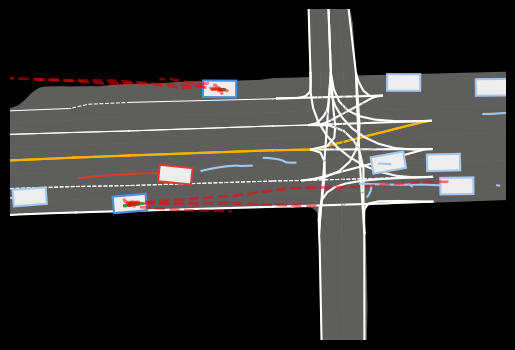

In [8]:
#%matplotlib widget
import matplotlib.pyplot as plt

from planner.data.viz import plot_scenario

BATCH_INDEX = 0

fig, ax = plt.subplots(1, 1)

# plot the scenario
ax = plot_scenario(
    scenario=data[BATCH_INDEX].to("cpu"), ax=ax, crop_to_bounds=True
)

scenario_id = data[BATCH_INDEX].scenario_id.decode("utf-8")
map_api = ds.get_map_api(scenario_id=scenario_id)
for _, area in map_api.vector_drivable_areas.items():
    ax.fill(area.xyz[..., 0], area.xyz[..., 1], color="#5E5E5D", zorder=0)

# plot the ground-truth observations
cum_target = target.cumsum(dim=-2) + current
for tar, val in zip(cum_target[BATCH_INDEX], tar_valid[BATCH_INDEX]):
    tar = tar[val]
    ax.plot(
        tar[..., 0].cpu().numpy(),
        tar[..., 1].cpu().numpy(),
        "g-",
        lw=2,
        alpha=0.75,
        zorder=10,
    )

# plot the predictions
cum_y_means = output.y_means.cumsum(dim=-2) + current.unsqueeze(-3)
cum_y_covars = output.y_covars.cumsum(dim=-3)
for y_means, val in zip(cum_y_means[BATCH_INDEX], tar_valid[BATCH_INDEX]):
    for y_mean in y_means:
        xy = y_mean[val][..., 0:2].cpu().numpy()
        ax.plot(
            xy[..., 0],
            xy[..., 1],
            "r--",
            lw=2,
            alpha=0.5,
            zorder=15,
        )

# ax = plot_full_uncertainty(
#     means=cum_y_means[BATCH_INDEX, 0, ..., 0:2].cpu().numpy(),
#     covars=cum_y_covars[BATCH_INDEX, 0, ..., 0:2, 0:2].cpu().numpy(),
#     mixtures=np.ones(6) / 6,
#     ax=ax,
#     n_std=1,
#     heatmap_type="log_prob",
#     alpha=0.75,
#     zorder=15,
# )
fig.set_facecolor("#000000")

In [9]:
from dataclasses import dataclass
import torch
@dataclass
class SeNeVAMOutput:

    means: torch.Tensor
    """torch.Tensor: The Gaussian means of shape `(*, K, T, 2)`."""
    covar: torch.Tensor
    """torch.Tensor:..."""

from scipy.stats import Normal

In [10]:
hist_traj = data.log_trajectory
hist_traj[data.object_property.is_sdc].shape

torch.Size([1, 110])